<a href="https://colab.research.google.com/github/samirgadkari/fastai_pytorch_book/blob/master/Tutorials_Imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code has been taken from: https://docs.fast.ai/tutorial.imagenette

It has been updated with comments from that page as well as my own.

Imagenette is a subset of ImageNet with 10 very different classes. It's great to quickly experiment before trying a fleshed-out technique on the full ImageNet dataset. We will show in this tutorial how to train a model on it, using the usual high-level APIs, then delving inside the fastai library to show you how to use the mid-level APIs we designed. This way you'll be able to customize your own data collection or training as needed.

In [2]:
# The U flag is to upgrade, 
# the q flag is for quiet installation
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [5]:
dls = ImageDataLoaders.from_folder(
    path, 
    valid='val',  # Train and Valid folder names can be given.
    item_tfms=RandomResizedCrop(128, min_scale=0.35), # Item transforms
    batch_tfms=Normalize.from_stats(    # Batch transforms
        *imagenet_stats                 # Global variable containing imagenet mean/sd as tuple of lists.
    )                                   # This is the same as cifar_stats, mnist_stats
)

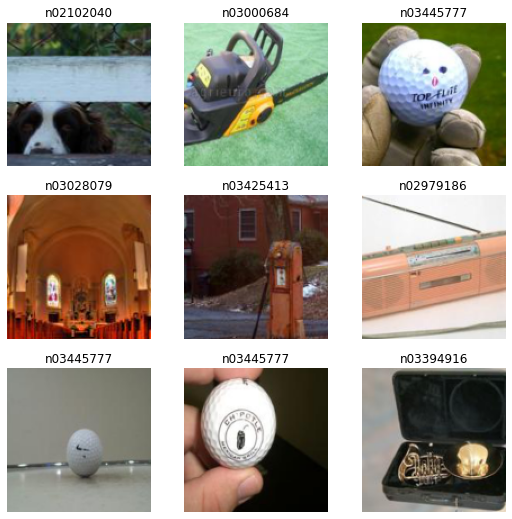

In [6]:
dls.show_batch()  # TfmdDL.show_batch() defaults to showing one batch
                  # of pipeline outputs.

In [7]:
fnames = get_image_files(path)

# DataBlock fundamentals

In [8]:
# This gives us an empty datablock (a recipe of what to do to data).
#   - You have to first pass it a source
#   - You can then convert it to a Datasets using dblock.datasets() or
#     to a DataLoaders using dblock.dataloaders().
#     The dblock.dataloaders() requires us to get the data ready for batches.
#     Here we don't have that, so we use datasets.
dblock = DataBlock()  # Recursively gets all image files from subfolders.
                      # If folders variable is set, it only looks in those folders.

In [9]:
dsets = dblock.datasets(fnames)
dsets.train[0]  # The datablock API assumes we have an input and a target.
                # This is why our filename is repeated twice.

(Path('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_15114.JPEG'),
 Path('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_15114.JPEG'))

In [10]:
# Instead, let us build a datablock with the get_items function set so it
# knows how to get the data.
dblock = DataBlock(get_items = get_image_files)

In [11]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/root/.fastai/data/imagenette2-160/val/n03888257/n03888257_30270.JPEG'),
 Path('/root/.fastai/data/imagenette2-160/val/n03888257/n03888257_30270.JPEG'))

In [12]:
# To convert our target to a label, use parent_label on the filename.
# But the output label is not very readable.
parent_label(fnames[0])

'n03394916'

In [13]:
# Instead, use this label mapping.
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [14]:
# and a label function
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [15]:
# apply label_func to get labels
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func) # Func that converts filename to label

dsets = dblock.datasets(path)
dsets.train[0]

(Path('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_14402.JPEG'),
 'tench')

In [16]:
# Tell the data block the types of our inputs/oututs.
# If you have more than one inputs/targets, 
# specify n_inp (number of inputs). The rest are targets.
# You also need to pass a list of functions to get_x/get_y
# to tell data block how to process each input/target.
dblock = DataBlock(blocks    = (ImageBlock,     # Inputs are images
                                CategoryBlock), # Outputs are categories
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter = GrandparentSplitter(),  # Train/Validation split using the Grandparent folder

                   # The item transforms and batch transforms are the same way
                   # as we do in the ImageDataLoaders factory methods.
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                   )

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=239x160, TensorCategory(1))

In [17]:
# The datablock API created a mapping from categories to index, called a vocab.
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

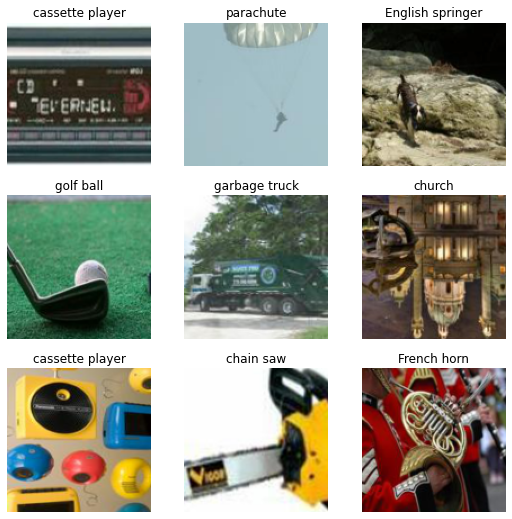

In [18]:
# Batch items together and convert to dataloaders using the dataloaders() function.
dls = dblock.dataloaders(path)
dls.show_batch()

In [19]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,

                       # Another way to compose the target using several functions
                       # is by using a pipeline
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

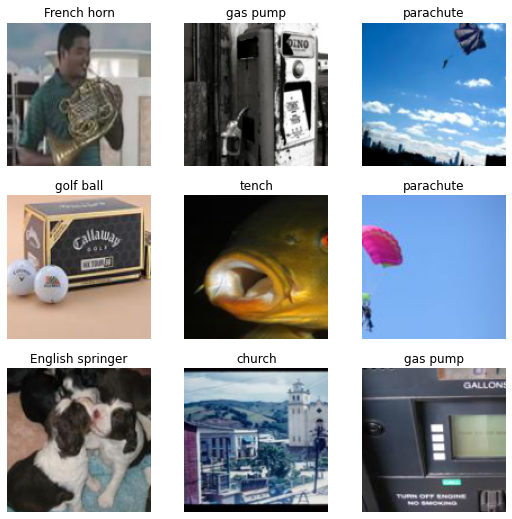

In [20]:
dls = imagenette.dataloaders(path)
dls.show_batch()

To learn more about the data block API: https://docs.fast.ai/tutorial.datablock

# Loading the data with the mid-level API (Transform, Datasets)

In [21]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

In [22]:
# Transformations applied to the filenames (here they are filenames),
# can be different if the type of the item given to the function
# is different. This is called type dispatch.
# Transformations are applied on each element of a tuple. ex:
#   (image, label) -> resize transform -> (resize(image), label)  # no resize on label
#                                                                 # since you cannot resize label
#   (image, mask)  -> resize transform -> (resize(image), resize(mask))
#
# A transform can have:
#   - A setup executed on the whole set (or whole training set). This is how
#     Categorize builds it's vocabulary automatically
#   - A decodes that undoes what the transform does for showing purposes (ex.
#     Categorize will convert an index back into a category)

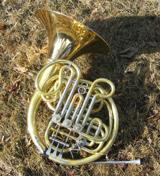

In [23]:
PILImage.create(fnames[0])

In [24]:
fnames[0]

Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_52232.JPEG')

In [25]:
lbl_dict[parent_label(fnames[0])]  # ex: n03394916 -> 'French horn'

'French horn'

In [26]:
# Compose several transforms using a pipeline
tfm = Pipeline([parent_label,                     # Get the parent labels.
                lbl_dict.__getitem__,             # Get's value at key in dict.
                Categorize(                       # Categorize to create labels.
                    vocab = lbl_dict.values()     # Pass in the labels explicitly.
                                                  # Categories will be the indices of vocab.
                    )]
               )
tfm(fnames[0])

TensorCategory(1)

In [27]:
# Split using grandparent directory of each filename.
splits = GrandparentSplitter(valid_name='val' # Folder name 'val' contains files for validation.
                            )(fnames)         # Pass in the filenames to run the splitter

In [28]:
dsets = Datasets(fnames,  # These are called items.
                 
                 # These are called transforms.
                 # Independent variables (filename) -> PILImage.create -> image created
                 # Dependent variable    (filename) -> parent_label 
                 #                          -> lbl_dict.__getitem__
                 #                          -> Categorize
                 [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]], 
                 splits=splits)

In [29]:
dsets[0]

(PILImage mode=RGB size=160x176, TensorCategory(1))

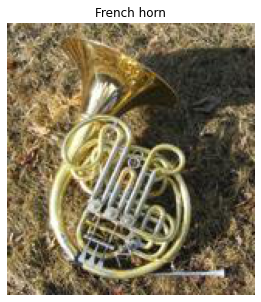

In [30]:
dsets.show(dsets[0]);

In [31]:
# To build a DataLoaders from this datasets, we need to add transforms
# on each input and target. Specifically, for this data, our images need to be:
#   - Resized
#   - Converted to tensors
item_tfms = [ToTensor,  # Convert to tensor
             RandomResizedCrop(   # Randomly crop and size image.
                 128,             # Final image size is 128 x 128 square.
                  min_scale=0.35) # When getting a random scale, this is the smallest
             ]                    # scale to apply to the image. So use
                                  # random.uniform(self.min_scale, 1.0) to get
                                  # the random scale value.

# We also need to apply batch-level transforms.
# These two transforms could be done per item as well, but it is way more efficient
# to apply these on batches.
# We did not need these for DataBlock API since default transforms are
# always applied based on the type for that API.
batch_tfms = [IntToFloatTensor,  # Convert int tensors to float and divide by 255
              Normalize.from_stats(*imagenet_stats)]  # Normalize using the imagenet statistics

In [32]:
dls = dsets.dataloaders(after_item=item_tfms,   # item_tfms are applied after the item has been formed.
                        after_batch=batch_tfms, # batch_tfms are applied after the batch has been formed.
                        bs=64,                  # batch size
                        num_workers=8)          # must be number of threads

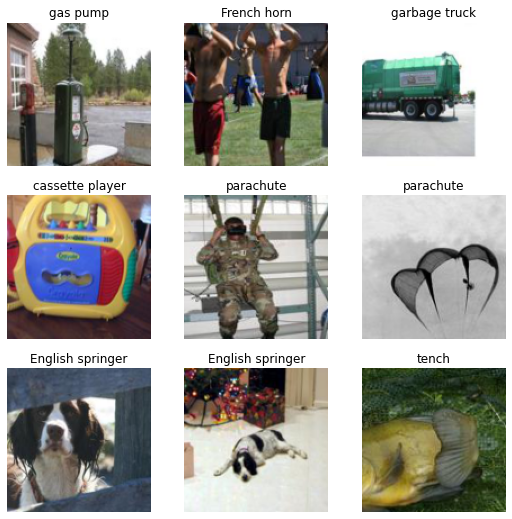

In [33]:
dls.show_batch()

# Training

In [34]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    pretrained=False)  # We want to build the model from scratch.
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.400577,2.039013,0.345732,00:30
1,2.251592,1.943082,0.324076,00:30
2,1.789631,1.589604,0.471338,00:30
3,1.508175,1.484585,0.517707,00:29
4,1.252658,1.135342,0.642293,00:30


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.00363078061491251)

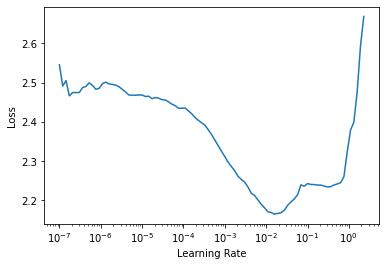

In [35]:
# Specify a new model to try using the Learner class.
# fastai has all the latest models, although they are not pre-trained.
# Using the Learner class we can train different models on the same data.
learn = Learner(dls,   # Dataloaders
                xresnet34(n_out=10), # Model. Since we have 10 classes, n_out = 10
                metrics=accuracy)
learn.lr_find()  # Find a good learning rate with lr_find.

In [36]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.624830,1.638834,0.451210,00:31
1,1.185269,1.105501,0.637197,00:31
2,0.966848,1.030243,0.670318,00:30
3,0.780853,0.768084,0.752357,00:31
4,0.676461,0.719043,0.766115,00:30


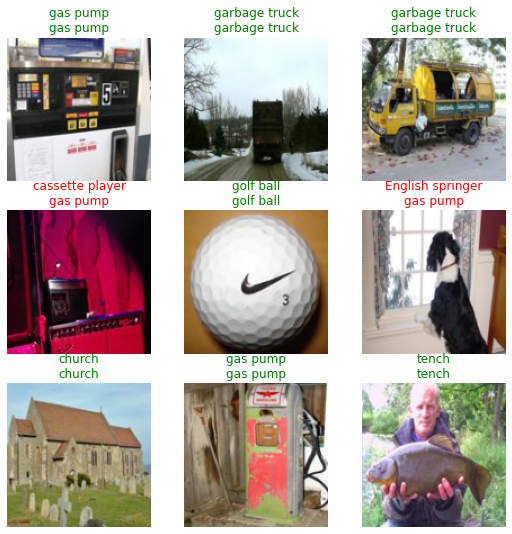

In [37]:
learn.show_results()

# Changing the loss function



In [39]:
# loss_function(output, target) -> loss
# Works with any pytorch function, but
# can cause problems with fastai functions like:
#   - Learner.get_preds
#     To get get_preds to work with with_loss = True
#     (which is also called when you run
#     ClassificationInterpretation.plot_top_losses for instance),
#     your loss function will need a "reduction" argument
#     which you can set to "none". This allows the pytorch
#     function to not reduce the loss to a single number (ex. sum/avg),
#     but to return something the same size as the target.
#   - Learner.predict, and Learner.show_results
#     They rely on two methods your loss function should have:
#       - if you have a loss that combines activation and loss function
#         (such as nn.CrossEntropyLoss), an activation function.
#       - a decodes function that converts your predictions to the same format
#         your targets are: for instance in the case of nn.CrossEntropyLoss, 
#         the decodes function should take the argmax.

In [40]:
# Here is a custom loss function doing label smoothing.
# We can pass this loss function to Learner.
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    # This the loss function (output, target) -> loss.
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    # since this loss function combines activation (softmax) with the actual loss, 
    # we implement activation that take the softmax of the output. 
    # This is what will make Learner.get_preds or Learner.predict return 
    # the actual predictions instead of the final activations.
    def activation(self, out): return F.softmax(out, dim=-1)

    # decodes changes the outputs of the model to put them in the same format 
    # as the targets (one int for each sample in the batch size) by taking 
    # the argmax of the predictions. 
    def decodes(self, out):    return out.argmax(dim=-1)

In [42]:
learn = Learner(dls, xresnet34(n_out=10), loss_func=LabelSmoothingCE(), metrics=accuracy)

# It's not training as well as before because label smoothing is a regularizing technique, 
# so it needs more epochs to really kick in and give better results.

In [43]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.775828,1.780208,0.490955,00:31
1,1.440114,1.419625,0.611975,00:31
2,1.246248,1.273507,0.697070,00:30
3,1.126480,1.139755,0.751083,00:31
4,1.031919,1.066463,0.778344,00:31


In [44]:
learn.predict(fnames[0])

('French horn',
 tensor(1),
 tensor([0.0139, 0.9285, 0.0021, 0.0111, 0.0092, 0.0049, 0.0056, 0.0159, 0.0030, 0.0058]))

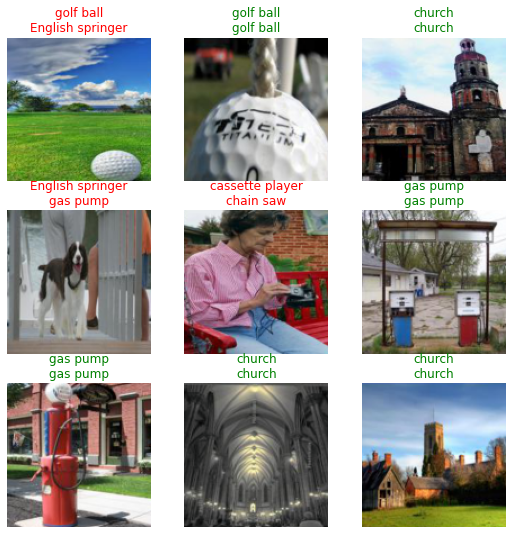

In [45]:
learn.show_results()

# Changing the optimizer

In [46]:
# fastai uses its own class of Optimizer built with various callbacks to refactor 
# common functionality and provide a unique naming of hyperparameters playing the 
# same role (like momentum in SGD, which is the same as alpha in RMSProp and beta0 in Adam) 
# which makes it easier to schedule them (such as in Learner.fit_one_cycle).

# It implements all optimizers supported by PyTorch (and much more) 
# so you should never need to use one coming from PyTorch. Checkout the optimizer module 
# to see all the optimizers natively available.

# However in some circumstances, you might need to use an optimizer that is not in fastai 
# (if for instance it's a new one only implemented in PyTorch). 
# Before learning how to port the code to our internal Optimizer 
# (checkout the optimizer module to discover how), you can use the OptimWrapper class 
# to wrap your PyTorch optimizer and train with it:

In [47]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(param_groups, **kwargs):
    return OptimWrapper(torch.optim.AdamW([{'params': ps, **kwargs} for ps in param_groups]))

In [49]:
# We write an optimizer function that expects param_groups, which is a list of list of parameters. 
# Then we pass those to the PyTorch optimizer we want to use.

In [50]:
# We can use the pytorch_adamw function and pass it to the opt_func argument of Learner:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3))

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.004365158267319202)

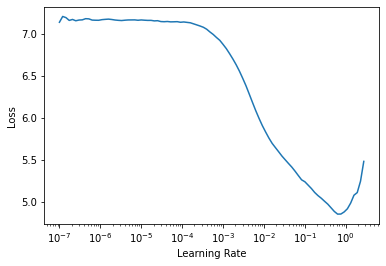

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.618407,2.627258,0.432357,00:28
1,2.157631,2.302197,0.550064,00:28
2,1.898091,1.880475,0.700127,00:28
3,1.717658,1.721798,0.757962,00:28
4,1.615924,1.633871,0.791083,00:28


# Changing the training loop with a Callback

In [54]:
# The base training loop in fastai is the same as pytorch's,
# where model, loss_func, opt are attributes of Learner.
# for xb,yb in dl:
#     pred = model(xb)
#     loss = loss_func(pred, yb)
#     loss.backward()
#     opt.step()
#     opt.zero_grad()

In [55]:
# To easily allow you to add new behavior in that training loop without needing to rewrite it yourself
# (along with all the fastai pieces you might want like mixed precision, 1cycle schedule, distributed training...), 
# you can customize what happens in the training loop by writing a callback.
# Callback basics:
#    a Callback can read every piece of a Learner, hence knowing everything happening in the training loop
#    a Callback can change any piece of the Learner, allowing it to alter the behavior of the training loop
#    a Callback can even raise special exceptions that will allow breaking points 
#      (skipping a step, a validation phase, an epoch or even cancelling training entirely)
#
# We will apply the Mixup callback to our training.
# mixup (https://arxiv.org/abs/1710.09412) provides regularization by
# giving a linear combination of inputs:
#   input = x1 * t + x2 * (1-t)  where  0 <= random number t <= 1
# For one-hot encoded targets:
#   target = y1 * t + y2 * (1-t)
# In practice though, targets are not one-hot encoded in PyTorch, 
# but it's equivalent to change the part of the loss dealing with y1 and y2 by:
#   loss = loss_func(pred, y1) * t + loss_func(pred, y2) * (1-t)
# because the loss function used is linear with respect to y.
# We just need to use the version with reduction='none' of the loss to do this 
# linear combination, then take the mean.

In [56]:
from torch.distributions.beta import Beta

class Mixup(Callback):
    run_valid = False
    
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    
    def before_batch(self):
        self.t = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        x1,self.y1 = self.x[shuffle],self.y[shuffle]
        self.learn.xb = (x1 * (1-self.t[:,None,None,None]) + self.x * self.t[:,None,None,None],)
    
    def after_loss(self):
        with NoneReduce(self.loss_func) as lf:
            loss = lf(self.pred,self.y1) * (1-self.t) + lf(self.pred,self.y) * self.t
        self.learn.loss = loss.mean()

In [57]:
# We can see we write two events:
#     before_batch is executed just after drawing a batch and before the model is run on the input. We first draw our random numbers t, following a beta distribution (like advised in the paper) and get a shuffled version of the batch (instead of drawing a second version of the batch, we mix one batch with a shuffled version of itself). Then we set self.learn.xb to the new input, which will be the on fed to the model.
#     after_loss is executed just after the loss is computed and before the backward pass. We replace self.learn.loss by the correct value. NoneReduce is a context manager that temporarily sets the reduction attribute of a loss to 'none'.
# Also, we tell the Callback it should not run during the validation phase with run_valid=False.
# To pass a Callback to a Learner, we use cbs=:

In [58]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(), cbs=Mixup(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3))


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.00363078061491251)

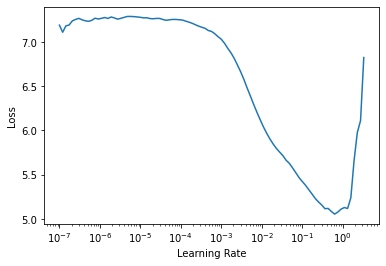

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.964516,3.252723,0.268790,00:29
1,2.528299,2.605735,0.432357,00:29
2,2.370753,1.979080,0.675414,00:28
3,2.237365,1.860156,0.719745,00:28
4,2.131031,1.782629,0.748535,00:29


In [ ]:
# Like label smoothing, this is a callback that provides more regularization, 
# so you need to run more epochs before seeing any benefit. 
# Also, our simple implementation does not have all the tricks of the 
# fastai's implementation, so make sure to check the official one in callback.mixup!